In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import ppscore as pps
import statsmodels.api as sm
import matplotlib.pyplot as plt
import feature_engine
from datetime import timedelta
from datetime import datetime
from sklearn.impute import SimpleImputer
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import sklearn
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from feature_engine.imputation import MeanMedianImputer
import math
import joblib
import pickle






In [2]:
excel_file_path = 'budgetusd.xlsx'
sheet_name = "Rooms Revenue"
df = pd.read_excel(excel_file_path, sheet_name=sheet_name)
# Load the Excel file into a pandas DataFrame


In [3]:
# This function will remove decimal points

def round_up_numeric(value):
    if pd.notnull(value) and isinstance(value, (int, float)):
        return math.ceil(value * 100) / 100
    return value

df =  df.applymap(round_up_numeric)

In [4]:
# Define replacements for multiple columns
column_replacements = {
    'Local Rainy Season': {"No": 0, "Medium": 1, "Yes": 2},
    'Seasonality': {"Low": 0, "Medium": 1, "High": 2}
}

# Map values in the specified columns
for col, replacements in column_replacements.items():
    df[col] = df[col].replace(replacements)


In [5]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)


In [6]:
df.drop(columns=['Rooms Revenue'], inplace=True)


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


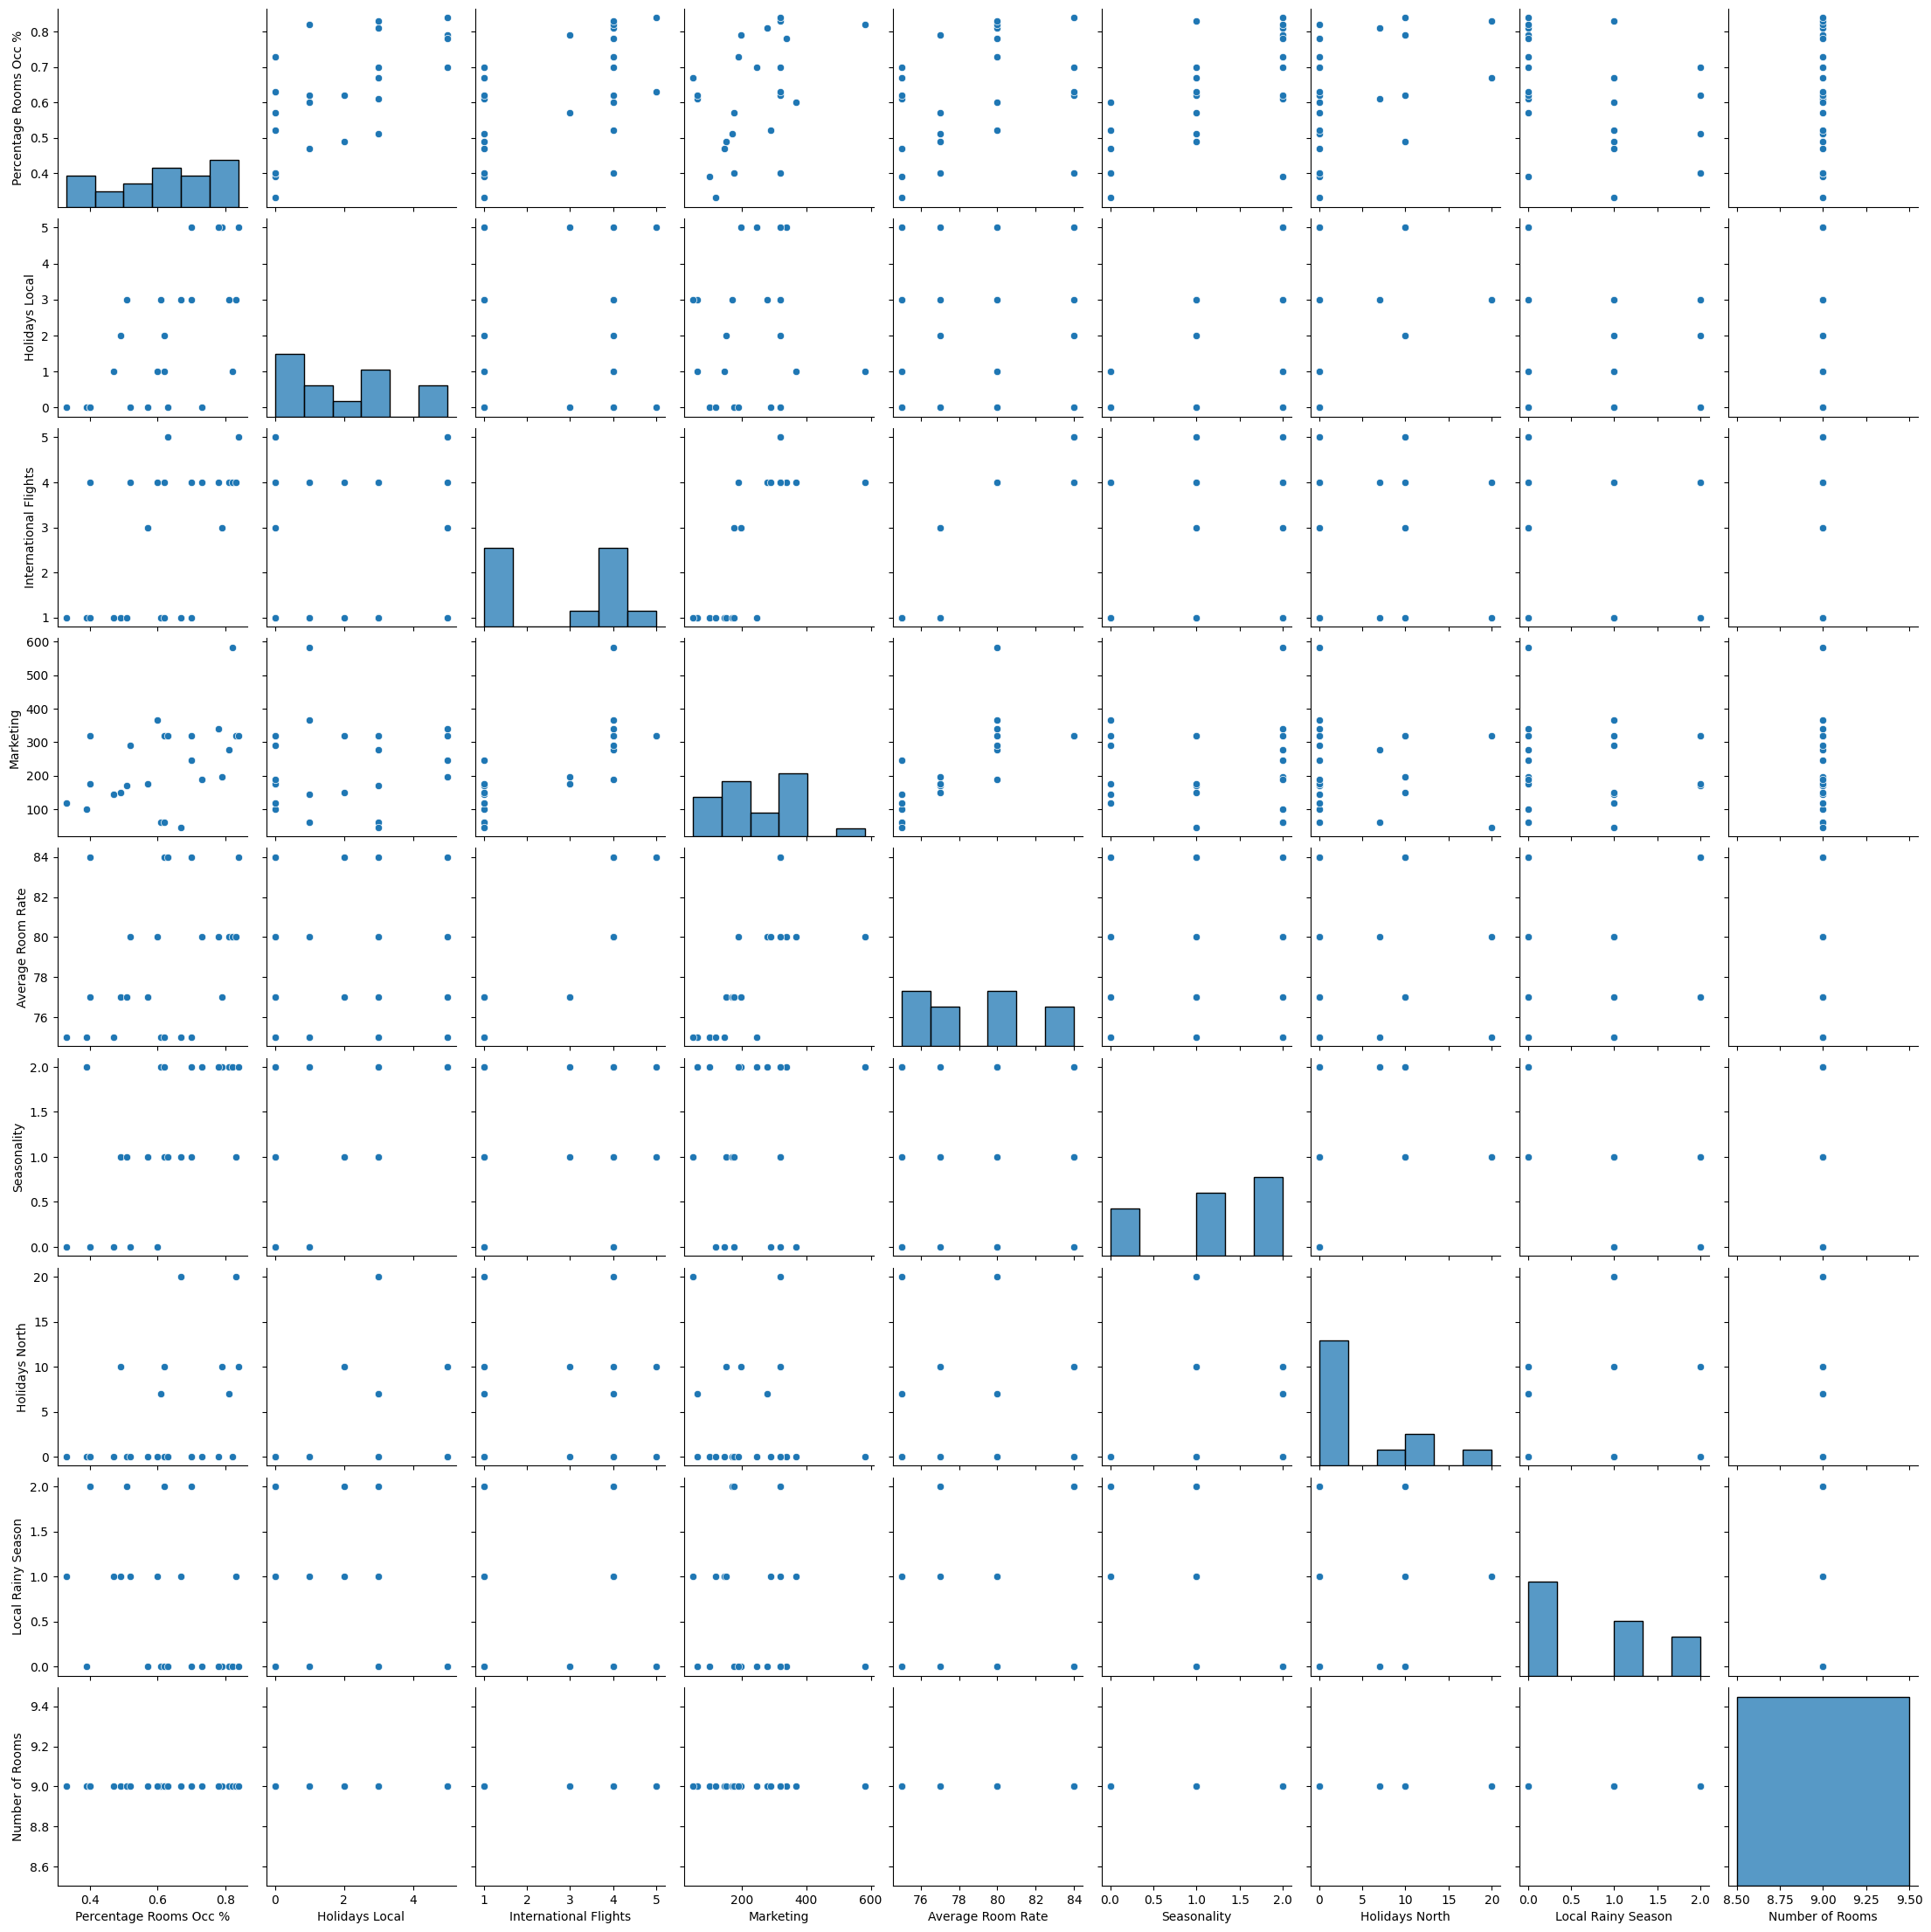

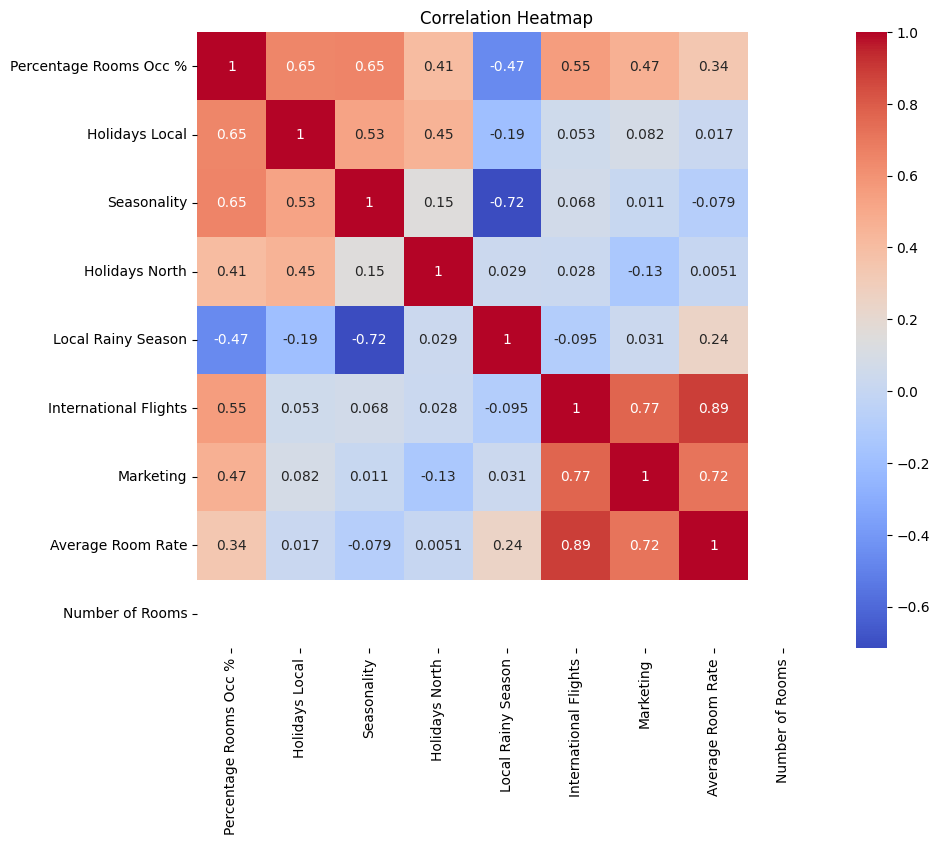

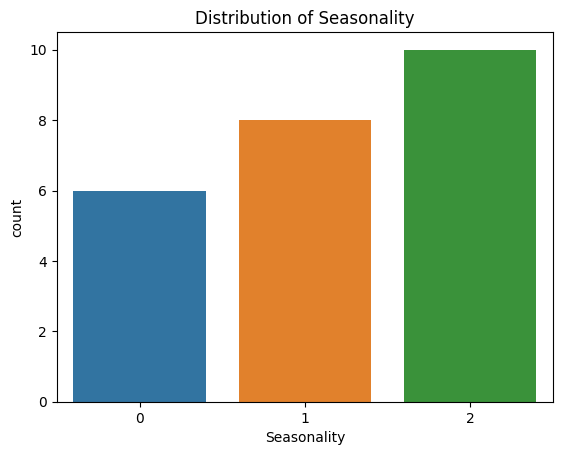

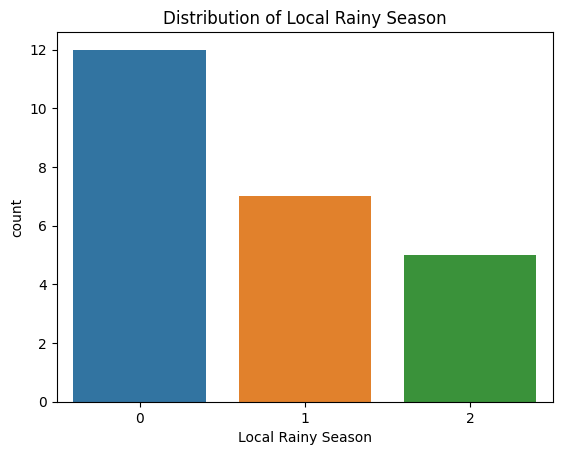

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plots for numerical variables 	
sns.pairplot(df, vars=['Percentage Rooms Occ %', 'Holidays Local', 'International Flights', 'Marketing', 'Average Room Rate', 
'Seasonality', 'Holidays North', 'Local Rainy Season', 'Number of Rooms'])
plt.show()

# Heatmap for numerical variable correlations
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Bar plots for categorical variables
categorical_cols = ['Seasonality', 'Local Rainy Season']
for col in categorical_cols:
    sns.countplot(data=df, x=col)
    plt.title(f"Distribution of {col}")
    plt.show()


### Split training and test sets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(['Percentage Rooms Occ %'], axis=1),
                                        df['Percentage Rooms Occ %'],
                                        test_size=0.2,
                                        random_state=(101))
print("* Train set:", X_train.shape, y_train.shape,"\n* Test set:", X_test.shape, y_test.shape)         



* Train set: (19, 8) (19,) 
* Test set: (5, 8) (5,)


In [9]:
# ML Algorithms 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

def pipeline_random_forest_reg():
    pipeline = Pipeline([
        ("feature_scaling", StandardScaler()),
        ("feature_selection", SelectFromModel(RandomForestRegressor(random_state=101))),
        ("model", RandomForestRegressor(random_state=101)),
])

    return pipeline
pipeline_random_forest_reg()

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestRegressor(random_state=101))),
                ('model', RandomForestRegressor(random_state=101))])

In [10]:
pipeline = pipeline_random_forest_reg()
pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestRegressor(random_state=101))),
                ('model', RandomForestRegressor(random_state=101))])

In [13]:
def feature_importance_tree_based_models(model, columns):
    """ Gets the mode, and the columns used to train the model
        we use the model.feature_importanes_ and columns to make a DataFrame that shows 
        the importance of each feature and then we print the features name and its relative 
        importance order, followed by a barplot indicating the importance
        """ 
    # Create DataFrame to display feature importance
    df_feature_importance = pd.DataFrame(data={
        'Features': columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    best_features = df_feature_importance['Features'].to_list()

    # Print the most important features and plot the feature importance
    print(f"* These are the {len(best_features)} most important features in descending order. The model was trained on them:")
    print(df_feature_importance['Features'].to_list())

    df_feature_importance.plot(kind='bar', x='Features', y='Importance')
    plt.show()

* These are the 3 most important features in descending order. The model was trained on them:
['Marketing', 'Seasonality', 'Holidays Local']


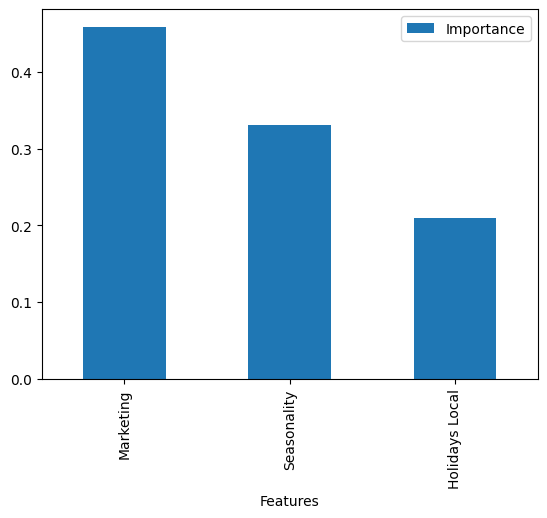

In [14]:
feature_importance_tree_based_models(model = pipeline['model'],
                                     columns = X_train.columns[pipeline['feature_selection'].get_support()])

In [11]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)

def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")

def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")
    
    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")
    
    plt.show()


Model Evaluation
* Train Set
R2 Score: 0.945
Mean Absolute Error: 0.028
Mean Squared Error: 0.001
Root Mean Squared Error: 0.035


* Test Set
R2 Score: 0.409
Mean Absolute Error: 0.104
Mean Squared Error: 0.012
Root Mean Squared Error: 0.111




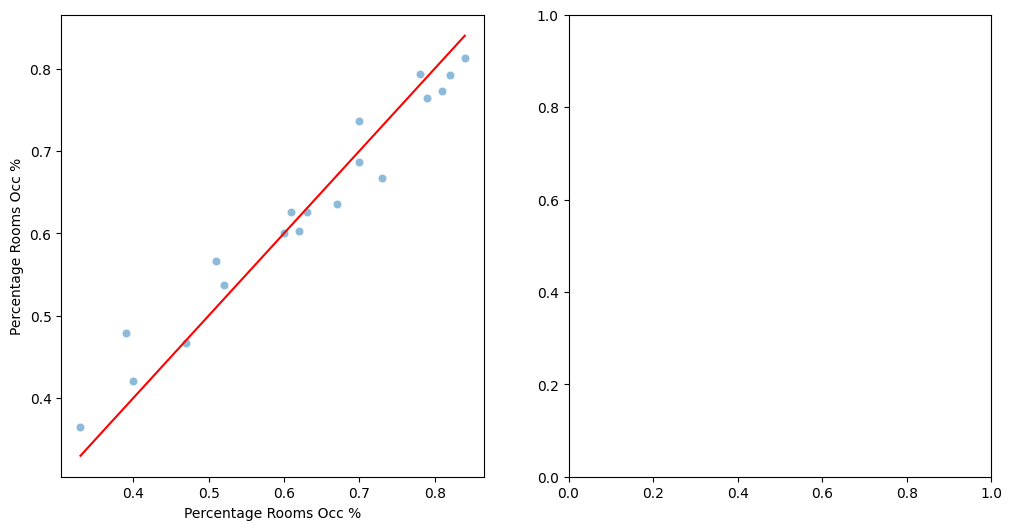

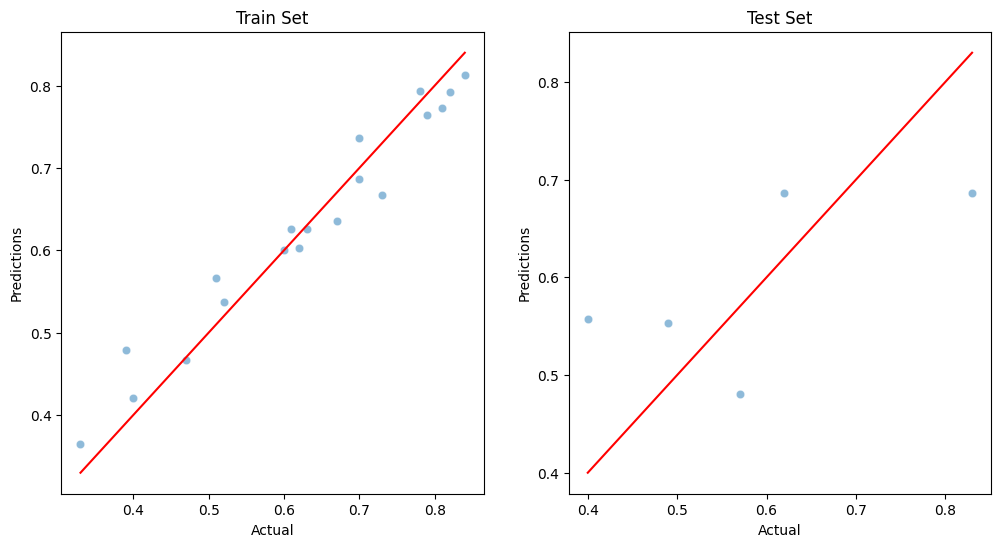

In [12]:
regression_performance(X_train, y_train, X_test, y_test, pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5)